device_target:Ascend
dataset_sink_mode:True
train_path:cifar-10-batches-bin
test_path:cifar-10-verify-bin


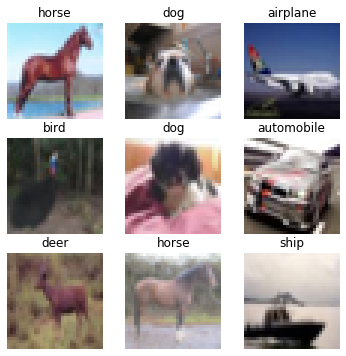

(125.306918046875, 122.950394140625, 113.86538318359375)
(62.99321927772381, 62.088707640401196, 66.70489964067347)
epoch: 1 step: 1562, loss is 1.9100706577301025
acc_eval:  0.2548
epoch time: 43619.270 ms, per step time: 27.925 ms
epoch: 2 step: 1562, loss is 1.470777988433838
acc_eval:  0.4676
epoch time: 4243.391 ms, per step time: 2.717 ms
epoch: 3 step: 1562, loss is 1.5791975259780884
acc_eval:  0.4487
epoch time: 4071.447 ms, per step time: 2.607 ms
epoch: 4 step: 1562, loss is 1.2728126049041748
acc_eval:  0.5116
epoch time: 3668.504 ms, per step time: 2.349 ms
epoch: 5 step: 1562, loss is 1.2537572383880615
acc_eval:  0.5631
epoch time: 3755.855 ms, per step time: 2.405 ms
epoch: 6 step: 1562, loss is 1.270367980003357
acc_eval:  0.5248
epoch time: 3976.637 ms, per step time: 2.546 ms
epoch: 7 step: 1562, loss is 1.2509448528289795
acc_eval:  0.5848
epoch time: 3871.723 ms, per step time: 2.479 ms
epoch: 8 step: 1562, loss is 1.3824923038482666
acc_eval:  0.5646
epoch time: 3

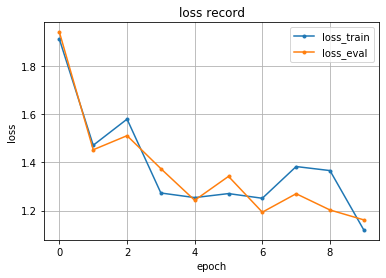

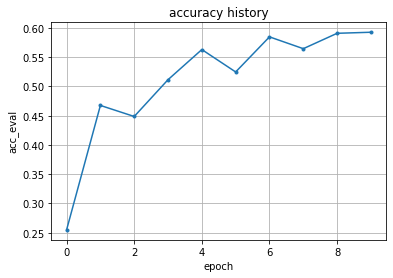

epoch: 1 step: 1000, loss is 1.2302467823028564
acc_eval:  0.5867867867867868
epoch time: 22397.676 ms, per step time: 22.398 ms
epoch: 2 step: 1000, loss is 0.8737604022026062
acc_eval:  0.6958958958958958
epoch time: 7292.422 ms, per step time: 7.292 ms
epoch: 3 step: 1000, loss is 0.693759560585022
acc_eval:  0.7351351351351352
epoch time: 6908.607 ms, per step time: 6.909 ms
epoch: 4 step: 1000, loss is 0.8054980635643005
acc_eval:  0.7574574574574574
epoch time: 7182.784 ms, per step time: 7.183 ms
epoch: 5 step: 1000, loss is 0.736717939376831
acc_eval:  0.7718718718718719
epoch time: 7273.383 ms, per step time: 7.273 ms
epoch: 6 step: 1000, loss is 0.858116865158081
acc_eval:  0.7878878878878879
epoch time: 7166.305 ms, per step time: 7.166 ms
epoch: 7 step: 1000, loss is 0.4806351959705353
acc_eval:  0.809009009009009
epoch time: 7143.749 ms, per step time: 7.144 ms
epoch: 8 step: 1000, loss is 0.6526490449905396
acc_eval:  0.8124124124124125
epoch time: 7316.224 ms, per step t

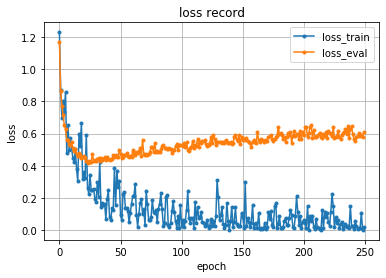

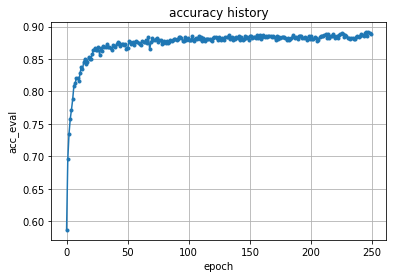

{'accuracy': 0.890990990990991, 'loss': 0.6033335209071815}


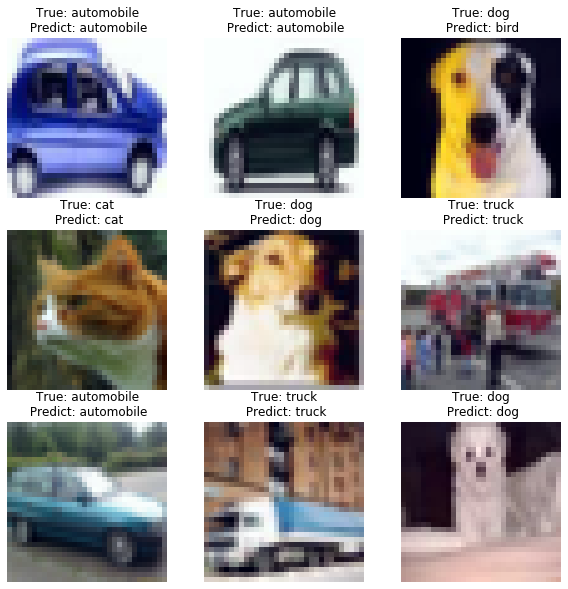

In [1]:
import mindspore
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.common import dtype as mstype
from mindspore.common.initializer import Normal
import mindspore.nn as nn
from mindspore.nn.metrics import Accuracy, Loss
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback
from mindspore import Model
from mindspore import save_checkpoint, load_checkpoint
from mindspore import context
import numpy as np
import matplotlib.pyplot as plt
import copy

import os, stat

device_target = context.get_context('device_target')
dataset_sink_mode = True if device_target in ['Ascend', 'GPU'] else False
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)
print(f'device_target:{device_target}')
print(f'dataset_sink_mode:{dataset_sink_mode}')
train_path = os.path.join(r'cifar-10-batches-bin')
test_path = os.path.join(r"cifar-10-verify-bin")
print(f'train_path:{train_path}')
print(f'test_path:{test_path}')
category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
demo_data = ds.Cifar10Dataset(test_path)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_data.create_dict_iterator():
    plt.subplot(3, 3, i)
    plt.imshow(dic['image'].asnumpy())  # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i += 1
    if i > 9:
        break

plt.show()

ds_train = ds.Cifar10Dataset(train_path)
# 计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray([x['image'] for x in ds_train.create_dict_iterator(output_numpy=True)])
RGB_mean = tuple(np.mean(tmp, axis=(0, 1, 2)))
RGB_std = tuple(np.std(tmp, axis=(0, 1, 2)))

print(RGB_mean)
print(RGB_std)


def create_dataset(data_path, batch_size=128, repeat_num=1, usage='train'):
    """
    数据处理

    Args:
        data_path (str): 数据路径
        batch_size (int): 批量大小
        usage (str): 训练或测试

    Returns:
        Dataset对象
    """

    # 载入数据集
    data = ds.Cifar10Dataset(data_path)

    # 打乱数据集
    data = data.shuffle(buffer_size=10000)

    # 定义算子
    if usage == 'train':
        trans = [
            CV.Normalize(RGB_mean, RGB_std),  # 数据标准化

            # 数据增强
            CV.RandomCrop([32, 32], [4, 4, 4, 4]),
            CV.RandomHorizontalFlip(),  # 随机翻转

            CV.HWC2CHW()  # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]
    else:
        trans = [
            CV.Normalize(RGB_mean, RGB_std),  # 数据标准化
            CV.HWC2CHW()  # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
        ]

    typecast_op = C.TypeCast(mstype.int32)  # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(input_columns='label', operations=typecast_op)
    data = data.map(input_columns='image', operations=trans)

    # 批处理
    data = data.batch(batch_size, drop_remainder=True)

    # 重复
    data = data.repeat(repeat_num)

    return data


class LeNet5(nn.Cell):
    """
    LeNet5网络

    Args:
        num_class (int): 输出分类数
        num_channel (int): 输入通道数
    Returns:
        Tensor, 输出张量

    Examples:
        >>> LeNet5(10, 3)
    """

    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')

        # 全连接层
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))

        # 激活函数
        self.relu = nn.ReLU()

        # 最大池化成
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # 网络展开
        self.flatten = nn.Flatten()

    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


train_data = create_dataset(train_path, batch_size=32, usage='train')
test_data = create_dataset(test_path, batch_size=50, usage='test')
network1 = LeNet5(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)

# 模型
model = Model(network=network1, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss': Loss()})


class TrainHistroy(Callback):
    """
    记录模型训练时每个epoch的loss的回调函数

    Args:
        history (list): 传入list以保存模型每个epoch的loss
    """

    def __init__(self, history):
        super(TrainHistroy, self).__init__()
        self.history = history

    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)


# 测试并记录模型在测试集的loss和accuracy，每个epoch结束时进行模型测试并记录结果，跟踪并保存准确率最高的模型网络参数
class EvalHistory(Callback):
    """
    记录模型训练时每个epoch在测试集的loss和accuracy的回调函数，并保存准确率最高的模型网络参数

    Args:
        model (Cell): 模型，评估loss和accuracy用
        loss_history (list): 传入list以保存模型每个epoch在测试集的loss
        acc_history (list): 传入list以保存模型每个epoch在测试集的accuracy
        eval_data (Dataset): 测试集，评估模型loss和accuracy用
    """

    # 保存accuracy最高的网络参数
    best_param = None

    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()
        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model

    # 每个epoch结束时执行
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)

        if len(self.acc_history) == 0 or res['accuracy'] >= max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)

        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])

        print('acc_eval: ', res['accuracy'])

    # 训练结束后执行
    def end(self, run_context):
        # 保存最优网络参数
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')

        if os.path.exists(best_param_path):
            # best_param.ckpt已存在时MindSpore会覆盖旧的文件，这里修改文件读写权限防止报错
            os.chmod(best_param_path, stat.S_IWRITE)

        save_checkpoint(self.best_param, best_param_path)


ckpt_path = os.path.join('.', 'results')  # 网络参数保存路径
hist = {'loss': [], 'loss_eval': [], 'acc_eval': []}  # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)

# 监控每次迭代的时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

# 监控loss值
loss_cb = LossMonitor(per_print_times=500)

# 记录每次迭代的模型损失值
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model=model,
                           loss_history=hist['loss_eval'],
                           acc_history=hist['acc_eval'],
                           eval_data=test_data)


epoch = 10 # 迭代次数
# 开始训练
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb], dataset_sink_mode=dataset_sink_mode) 

# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist) 

def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist) 




class LeNet5_2(nn.Cell):

    # 定义算子
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5_2, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 16*8, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(16*8, 32*8, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(32*8, 64*8, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.bn3 = nn.BatchNorm2d(512)
        self.fc1 = nn.Dense(64 * 2 *2*8, 60*8, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(60*8, 42*8, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(42*8, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class

    # 构建网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
 
        return x


train_data = create_dataset(train_path, batch_size=50, usage='train')
# 测试数据集预处理
test_data = create_dataset(test_path, batch_size=30, usage='test')
network2 = LeNet5_2(10)

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
net_opt = nn.Adam(params=network2.trainable_params())

# 模型
model = Model(network=network2, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss': Loss()})
hist = {'loss': [], 'loss_eval': [], 'acc_eval': []}  # 训练过程记录

# 网络参数自动保存，这里设定每2000个step保存一次，最多保存10次
config_ck = CheckpointConfig(save_checkpoint_steps=2000, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet_2', directory=ckpt_path, config=config_ck)

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model=model,
                           loss_history=hist['loss_eval'],
                           acc_history=hist['acc_eval'],
                           eval_data=test_data)

# 迭代次数
epoch = 250
# 开始训练
model.train(epoch, train_data,
            callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, LossMonitor(per_print_times=500)],
            dataset_sink_mode=dataset_sink_mode)
plot_loss(hist)
plot_accuracy(hist)
best_param = mindspore.load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network2)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

data_path = os.path.join('data', '10-verify-bin')

demo_data = create_dataset(test_path, batch_size=1, usage='test')


# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


# 设置图像大小
plt.figure(figsize=(10, 10))
i = 1
# 打印9张子图
for dic in demo_data.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(), axis=1)[0]  # 反馈可能性最大的类别

    # 可视化
    plt.subplot(3, 3, i)
    input_image = np.squeeze(input_img.asnumpy(), axis=0)  # 删除batch维度，方便可视化
    input_image = input_image.transpose(1, 2, 0)  # CHW转HWC，方便可视化
    input_image = normalize(input_image)  # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s' % (category_dict[dic['label'].asnumpy().item()], category_dict[predict]))
    i += 1
    if i > 9:
        break

plt.show()
